In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.ndimage import gaussian_filter1d

### The Big Problem

In notebook $B$, I explored how Gaussian Process optimization can be used to maximize an unknown function while remaining sample-efficient. In notebook $D$, I extended this setting to account for energy constraints, where moving between sampling locations incurs a limited budgetary cost. In both cases, I assumed that the function of interest could be observed directly at a chosen location.

In many real deployments, this assumption does not hold. For example, when an autonomous vehicle is tasked with locating regions of high animal density, the density itself is never observed. Instead, the vehicle receives only binary observations at each timestep (e.g. whether an animal is detected or not).

If you imagine a discrete set of locations this then corresponds to something known as the multi-armed bandit problem.

### Stochastic Bernoulli Multi-Armed Bandit

You have a set of arms to choose from, each of which has a probability of you winning when you pull it. A good solution explores the available options and exploits once it finds a good one. One approach is called Thompson Sampling and means choosing the lever which has the highest probability, after sampling it from the current posterior. Each one can be modelled with a beta distribution, which gives us something like this:

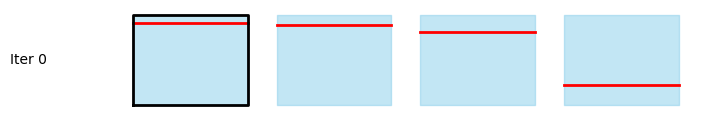

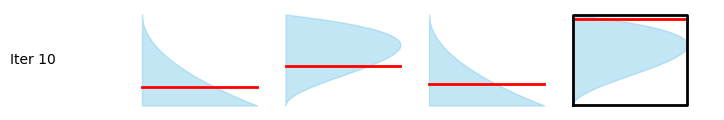

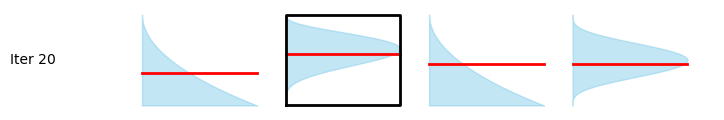

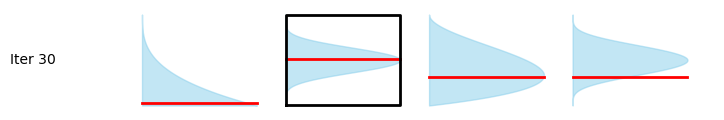

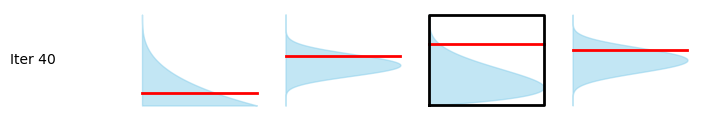

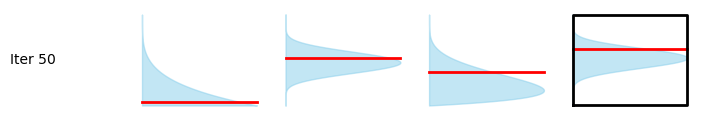

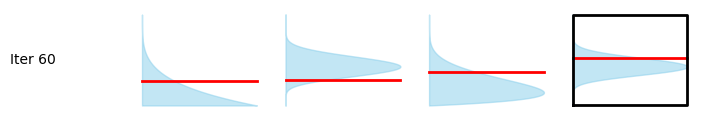

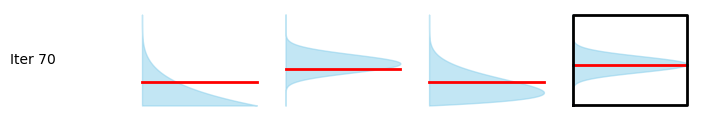

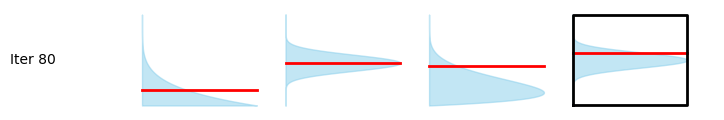

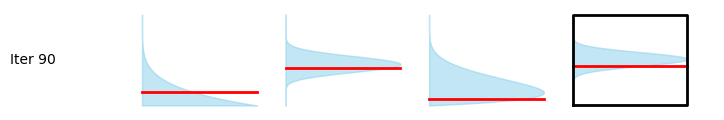

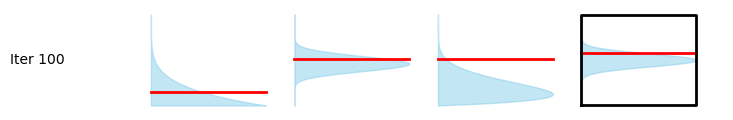

In [2]:
def show_bandits(beta_A, beta_B, sampled=None, chosen=None, iteration=None, res=400, width=0.8):
    beta_A, beta_B = np.asarray(beta_A), np.asarray(beta_B)
    y = np.linspace(0, 1, res)
    n = len(beta_A)
    fig, ax = plt.subplots(figsize=(1.5*n, 1))
    for i, (a, b) in enumerate(zip(beta_A, beta_B)):
        pdf = beta.pdf(y, a, b)
        pdf = pdf / pdf.max() * width
        ax.fill_betweenx(y, i, i + pdf, alpha=0.5, color='skyblue')
        if sampled is not None:
            ax.plot([i, i + width], [sampled[i]]*2, color='red', lw=2)
        if chosen is not None and i == chosen:
            ax.plot([i, i+width, i+width, i, i], [0,0,1,1,0], color='black', lw=2)
    ax.axis('off')
    
    if iteration is not None:
        ax.text(-0.6, 0.5, f"Iter {iteration}", fontsize=10, va='center', ha='right')
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    plt.show()

p = np.array([0.2, 0.6, 0.05, 0.4])
beta_A = np.ones(len(p))
beta_B = np.ones(len(p))
for t in range(101):
    sampled_probabilities = np.random.beta(beta_A, beta_B)
    chosen = np.argmax(sampled_probabilities)
    if t % 10 == 0:
        show_bandits(beta_A, beta_B, sampled=sampled_probabilities, chosen=chosen, iteration=t)
    if np.random.rand() < p[chosen]:
        beta_A[chosen] += 1
    else:
        beta_B[chosen] += 1

This model always keeps open the posibility that another arm could be better, but weights the benefits of trying it against the likelihood of success.

Of course, our scenario is a bit different in several ways. 

1. **Continuous surface:** We are interested in a continuous spatial region, not a fixed set of discrete arms. Learning about one location gives partial information about nearby locations.
2. **Movement cost:** A vehicle moving to collect data incurs a physical or energy cost, as explored in Notebook $D$.
3. **Passive, continuous sampling:** If the sensor is always on, we are not choosing discrete sampling locations; instead, the vehicle continuously gathers observations from the area it moves through.

The challenge now is to extend the bandit framework to a continuous spatial domain where the vehicle moves and continuously samples. This could be called **informative path planning** on a **spatially-correlated bandit**.

### Working in continuous space

To start, let's just imagine a robot which is experiencing some probability of an event per unit time, which changes over time.

E.g., say

$$200e^{-20(t-0.5)^2}$$

Just sampling from this is a challenge. One option is to discretize the function and then approximate the samples in each bin as all being in the same location. Then you just need to sample the poisson counts per bin. Poisson is the distribution over counts for a given time range with a fixed rate. 

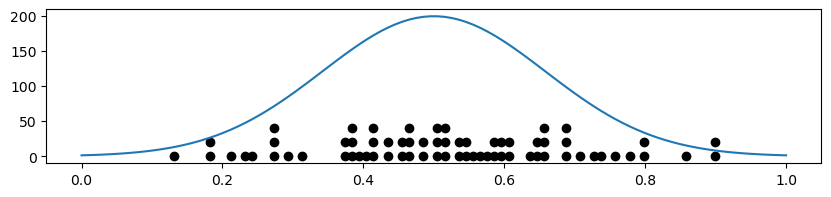

In [3]:
t = np.linspace(0,1,100)
dt = (t[-1]-t[0])/len(t)
p_dt = 200*np.exp(-20*(t-0.5)**2)
plt.figure(figsize=(10,2))
plt.plot(t, p_dt)
mean_events = p_dt * dt
event_samples = np.random.poisson(mean_events)
max_events = np.max(event_samples)
for events in range(1,int(max_events)):
    plt.scatter(t[event_samples>=events], np.ones(np.sum(event_samples>=events))*(events-1)*20, color="black")
plt.show()

Here the black points are samples, stacked if multiple occur in a particular time band.

Now, given a fixed robot path through some space we get something that looks like the above.

For instance, imagine a 2d variant of above, with some little robot going around.

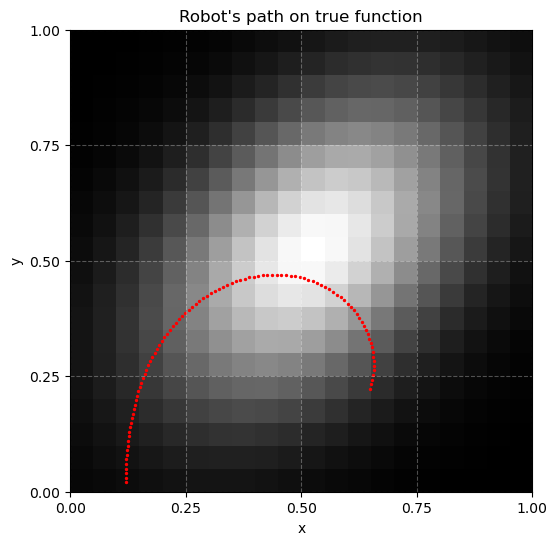

In [4]:
# --- Grid and probability field setup ---
grid_size = 20
X = np.mgrid[:grid_size, :grid_size].reshape(2, -1).T / grid_size
center = np.array([0.5, 0.5])
coef = np.array([[0.05, 0.02], [0.02, 0.05]])
inv_coef = np.linalg.inv(coef)

# Compute the field over the grid
delta_grid = X - center
p_grid = 200 * np.exp(-0.5 * np.einsum('ni,ij,nj->n', delta_grid, inv_coef, delta_grid))
p_grid = p_grid.reshape(grid_size, grid_size)

# --- Robot motion setup ---
robot_pos = np.array([0.12, 0.01])
robot_velocity = 0.01
robot_angle = np.pi / 2
angle_inc = -0.01
angle_inc2 = -0.0005
n_steps = 100

path = np.zeros((n_steps, 2))
for i in range(n_steps):
    robot_pos += robot_velocity * np.array([np.cos(robot_angle), np.sin(robot_angle)])
    path[i] = robot_pos
    
    robot_angle += angle_inc
    angle_inc += angle_inc2

delta_path = path - center
p_dt_path = 200 * np.exp(-0.5 * np.einsum('ni,ij,nj->n', delta_path, inv_coef, delta_path))

# --- Plot ---
plt.figure(figsize=(6,6))
plt.imshow(p_grid, origin='lower', extent=[0, 1, 0, 1], cmap='gray', aspect='equal')
plt.scatter(path[:,0], path[:,1], color='red', s=2)  # path points
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.linspace(0,1,5))
plt.yticks(np.linspace(0,1,5))
plt.title("Robot's path on true function")
plt.grid(color='white', linestyle='--', alpha=0.3)
plt.show()

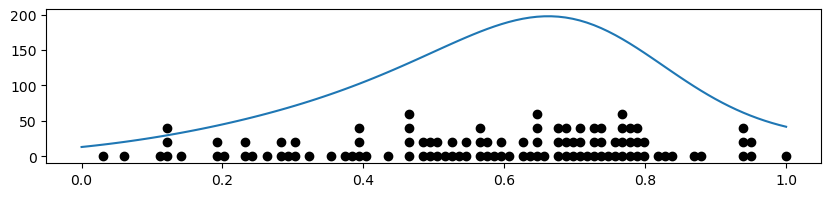

In [5]:
dt = (1 / len(p_dt_path))
mean_events = p_dt_path * dt # (assuming the whole journey took 1 unit time)
event_samples = np.random.poisson(mean_events)
max_events = np.max(event_samples)
plt.figure(figsize=(10,2))
plt.plot(np.linspace(0,1,len(p_dt_path)), p_dt_path)
for events in range(1,int(max_events)):
    t = np.linspace(0,1,len(p_dt_path))
    plt.scatter(t[event_samples>=events], np.ones(np.sum(event_samples>=events))*(events-1)*20, color="black")
plt.show()

Great. So now we can take some 2d function of the probability per unit time (here an unnormalized gaussian), and we can trace an arbitrary path along it and generate some hypothetical data for that path.

Now if we can take this data and infer the underlying function then we can also try to optimize for it. 

So we ask: Given a path taken by the robot and a sequence of timestamped events how do you infer the underlying probability of an event per unit time?

### Possible solutions

One option is to first estimate the curve just along the trajectory. Then later we can think about how to generalize it. This means infering blue from the black above. 

Of course, to properly do this we need to invert a Poisson Process. But that can be expensive. 

We can crudely just do an estimate based on the empirical values. If an event has a rate of $x$ per unit time over a time period $y$ then you get $xy$ samples. So we just divide the number of samples by the time to get the rate:

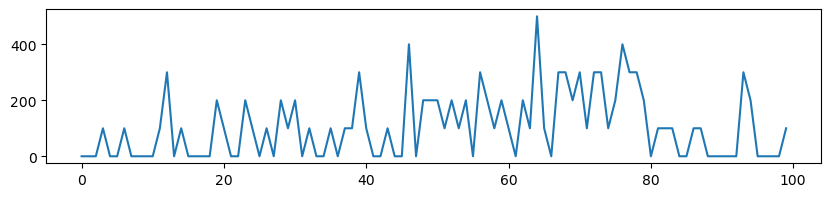

In [6]:
blue_estimate = event_samples / dt
plt.figure(figsize=(10,2))
plt.plot(blue_estimate)
plt.show()

But this is very noisy.

We can smooth it (or else do some kernel regression)...

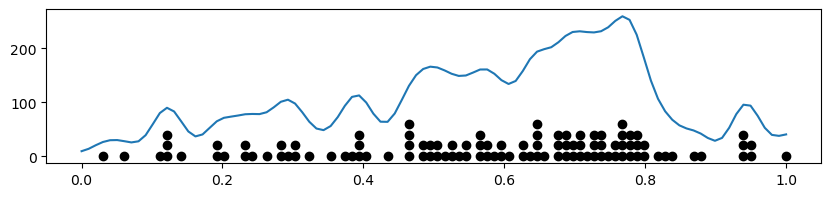

In [7]:
blue_estimate_smooth = gaussian_filter1d(blue_estimate, sigma=2)
plt.figure(figsize=(10,2))
plt.plot(np.linspace(0,1,len(p_dt_path)), blue_estimate_smooth)
for events in range(1,int(max_events)):
    plt.scatter(t[event_samples>=events], np.ones(np.sum(event_samples>=events))*(events-1)*20, color="black")
plt.show()

And finally given this curve you could try and to estimate the landscape, maybe using something like a Gaussian Process.

In [8]:
def rbf_kernel(Xa, Xb, lengthscale=0.5):
    sqdist = (
        np.sum(Xa**2, axis=1)[:, None]
        + np.sum(Xb**2, axis=1)[None, :]
        - 2 * Xa @ Xb.T
    )
    return np.exp(-sqdist / (2 * lengthscale**2))

def condition_gaussian(mean, cov, known_indicies, known_values):
    mean = np.asarray(mean)
    cov = np.asarray(cov)

    known_indicies = np.asarray(known_indicies)
    known_values = np.asarray(known_values)

    all_indicies = np.arange(len(mean))
    unknown_indicies = np.setdiff1d(all_indicies, known_indicies)

    mu_k = mean[known_indicies]
    mu_u = mean[unknown_indicies]

    Sigma_kk = cov[np.ix_(known_indicies, known_indicies)]
    Sigma_ku = cov[np.ix_(known_indicies, unknown_indicies)]
    Sigma_uk = cov[np.ix_(unknown_indicies, known_indicies)]
    Sigma_uu = cov[np.ix_(unknown_indicies, unknown_indicies)]

    Sigma_kk_inv = np.linalg.inv(Sigma_kk)

    cond_mean = mu_u + Sigma_uk @ Sigma_kk_inv @ (known_values - mu_k)
    cond_cov = Sigma_uu - Sigma_uk @ Sigma_kk_inv @ Sigma_ku

    return cond_mean, cond_cov

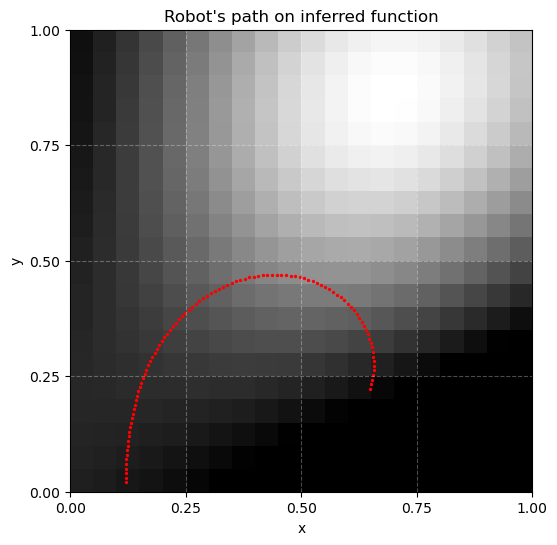

In [9]:
combined_points = np.concatenate([path,X],axis=0)
GP_cov = rbf_kernel(combined_points,combined_points) + 1e-1 * np.eye(len(combined_points)) # strong regularization needed
mean, cov = condition_gaussian(np.zeros(len(combined_points)),GP_cov,np.arange(len(path)),blue_estimate_smooth)
mean = mean * (mean > 0) # really a GP is a bit dumb here as we are dealing with probabilities

plt.figure(figsize=(6,6))
plt.imshow(mean.reshape(grid_size,grid_size).T, origin='lower', extent=[0, 1, 0, 1], cmap='gray', aspect='equal')
plt.scatter(path[:,0], path[:,1], color='red', s=2)  # path points
plt.xlabel('x')
plt.ylabel('y')
plt.xticks(np.linspace(0,1,5))
plt.yticks(np.linspace(0,1,5))
plt.title("Robot's path on inferred function")
plt.grid(color='white', linestyle='--', alpha=0.3)
plt.show()

Nice! So the robot here can take its current trajectory and the events over time and calculate a reasonable estimate for the original events-per-unit-time function!

One option is to just try and optimize straight away. Or maybe we do something more like Thompson Sampling from before? How do you plan a trajectory? Else what about doing so on an energy budget? Fortunately in this scenario there isn't a cost to sample.

What I would like to do now is approach this problem properly. Just dealing with a given robot trajectory means inverting an **Inhomogeneous Poisson process**. But then you also need to make inferences about the surrounding landscape, AND THEN, if you're feeling up for a challenge you need to get the robot moving in the right direction. Bonus points for doing so on an energy budget.

A good research question could be this:

*How do you optimize the direction of a moving sampler on an Inhomogenous Poisson Process?*